# Plotting for NAS-Bench-Suite Predictors

This notebook was used to plot the performance predictor experiments from Section 4 of 
[NAS-Bench-Suite: NAS Evaluation is (Now) Surprisingly Easy](https://arxiv.org/abs/2201.13396). This includes plotting the results of MLP, XGBoost, RF, BOHAMIANN, GP, and NAO.

In [190]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
import sys
import os
import copy
import numpy as np
import json
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import kendalltau
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
# method that gathers all of the results

# example result path:
# ~/results_nas_bench_suite/predictor_hpo_sep24/predictor_hpo_sep24_50/hpo_52/nasbench201/cifar100/xgb/3/errors.json

def get_hpo_results(predictors, search_spaces, root):
    results_dict = {}
    root = os.path.expanduser(root)
    for seed_header in os.listdir(root):
        for seed_dir in os.listdir(root + '/' + seed_header):
            hpo_seed = int(seed_dir.split('_')[-1])
            hpo_seed_dict = {}
            seed_path = root + '/' + seed_header + '/' + seed_dir
            for search_space in search_spaces:
                search_space_dict = {}
                for predictor in predictors:
                    predictor_path = seed_path + '/' + file_dict[search_space] + '/' + predictor
                    values = []
                    if os.path.exists(predictor_path):
                        for seed in os.listdir(predictor_path):
                            result_path = predictor_path + '/' + seed + '/errors.json'
                            if os.path.isfile(result_path):
                                result = json.load(open(result_path))
                                value = result[1]['spearman']
                                if not np.isnan(value):
                                    values.append(value)
                        if len(values) >= 3:
                            search_space_dict[predictor] = [np.mean(values), np.std(values)]
                        else:
                            print(len(values), 'not enough values', hpo_seed, search_space, predictor)
                hpo_seed_dict[search_space] = search_space_dict
            results_dict[hpo_seed] = hpo_seed_dict
    return results_dict

In [199]:
# Define constants that will be used throughout the notebook

"""
Set up colors. There are 11 colors defined in 'defaults', and 3 markers/formats for the plot lines.
So there are 33 color/markers total.
"""

defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0)
           ]

fmts = ['-', '--', ':', '-.']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]

color_dict={
    'bohamiann':{'color':defaults[0], 'fmt':fmts[0]},
    'gp':{'color':defaults[1], 'fmt':fmts[0]},
    'nao':{'color':defaults[2], 'fmt':fmts[0]},
    'mlp':{'color':defaults[2], 'fmt':fmts[0]},
    'rf':{'color':defaults[3], 'fmt':fmts[0]},
    'xgb':{'color':defaults[4], 'fmt':fmts[0]},
}

# how the predictor names will be displayed in the plot legends:
pred_label_dict={
    'mlp':'MLP', 'xgb':'XGBoost', 'rf':'RF', 'bohamiann':'BOHAMIANN', 
    'gp':'GP', 'nao':'NAO', 
}

In [175]:
# search space constants

# how the search space names will be displayed in the plot titles:
ss_dict_lined = {'nb101':'NB-101\n CIFAR10', 
                 'nb201_c10':'NB-201\n CIFAR10', 
                 'nb201_c100':'NB-201\n CIFAR100', 
                 'nb201_im':'NB-201\n ImageNet', 
                 'darts':'DARTS\n CIFAR10',
                 'nlp':'NB-NLP\n TreeBank',
                 'asr':'NB-ASR\n TIMIT',
                 'mr_3ddet':'NB-MR\n KITTI',
                 'mr_cls':'NB-MR\n ImageNet',
                 'mr_seg':'NB-MR\n City',
                 'mr_video':'NB-MR\n HMDB51',
                 'transmicro_obj':'TNB-Micro\n Object', 
                 'transmicro_scene':'TNB-Micro\n Scene', 
                 'transmicro_jigsaw':'TNB-Micro\n Jigsaw', 
                 'transmicro_room':'TNB-Micro\n Room',
                 'transmicro_segment':'TNB-Micro\n Semantic', 
                 'transmicro_normal':'TNB-Micro\n Surface', 
                 'transmicro_auto':'TNB-Micro\n Autoenc.', 
                 'transmacro_obj':'TNB-Macro\n Object', 
                 'transmacro_scene':'TNB-Macro\n Scene', 
                 'transmacro_jigsaw':'TNB-Macro\n Jigsaw', 
                 'transmacro_room':'TNB-Macro\n Room',
                 'transmacro_segment':'TNB-Macro\n Semantic', 
                 'transmacro_normal':'TNB-Macro\n Surface', 
                 'transmacro_auto':'TNB-Macro\n Autoenc.', 
          }

# single-line version of the search space names:
ss_dict_oneline = {'nb101':'NB-101 CIFAR10', 
                 'nb201_c10':'NB-201 CIFAR10', 
                 'nb201_c100':'NB-201 CIFAR100', 
                 'nb201_im':'NB-201 ImageNet', 
                 'darts':'DARTS CIFAR10',
                 'nlp':'NB-NLP TreeBank',
                 'asr':'NB-ASR TIMIT',
                 'mr_3ddet':'NB-MR KITTI',
                 'mr_cls':'NB-MR ImageNet',
                 'mr_seg':'NB-MR City',
                 'mr_video':'NB-MR HMDB51',
                 'transmicro_obj':'TNB-Micro Object', 
                 'transmicro_scene':'TNB-Micro Scene', 
                 'transmicro_jigsaw':'TNB-Micro Jigsaw', 
                 'transmicro_room':'TNB-Micro Room',
                 'transmicro_segment':'TNB-Micro Semantic', 
                 'transmicro_normal':'TNB-Micro Surface', 
                 'transmicro_auto':'TNB-Micro Autoenc.', 
                 'transmacro_obj':'TNB-Macro Object', 
                 'transmacro_scene':'TNB-Macro Scene', 
                 'transmacro_jigsaw':'TNB-Macro Jigsaw', 
                 'transmacro_room':'TNB-Macro Room',
                 'transmacro_segment':'TNB-Macro Semantic', 
                 'transmacro_normal':'TNB-Macro Surface', 
                 'transmacro_auto':'TNB-Macro Autoenc.', 
          }

# abbreviations used for the matrix plots:
ss_dict_mat = {'nb101':'NB-101', 
                 'nb201_c10':'NB-201', 
                 'nb201_c100':'NB-201', 
                 'nb201_im':'NB-201', 
                 'darts':'DARTS',
                 'nlp':'NB-NLP',
                 'asr':'NB-ASR',
                 'mr_3ddet':'NB-MR',
                 'mr_cls':'NB-MR',
                 'mr_seg':'NB-MR',
                 'mr_video':'NB-MR',
                 'transmicro_obj':'TNB-Micro', 
                 'transmicro_scene':'TNB-Micro', 
                 'transmicro_jigsaw':'TNB-Micro', 
                 'transmicro_room':'TNB-Micro',
                 'transmicro_segment':'TNB-Micro', 
                 'transmicro_normal':'TNB-Micro', 
                 'transmicro_auto':'TNB-Micro', 
                 'transmacro_obj':'TNB-Macro', 
                 'transmacro_scene':'TNB-Macro', 
                 'transmacro_jigsaw':'TNB-Macro', 
                 'transmacro_room':'TNB-Macro',
                 'transmacro_segment':'TNB-Macro', 
                 'transmacro_normal':'TNB-Macro', 
                 'transmacro_auto':'TNB-Macro', 
          }

# these are the file paths we used
file_dict = {
    'nb101':'nasbench101/cifar10', 
    'nb201_c10':'nasbench201/cifar10', 
    'nb201_c100':'nasbench201/cifar100', 
    'nb201_im':'nasbench201/ImageNet16-120', 
    'darts':'darts/cifar10', 
    'nlp':'nlp/penntreebank', 
    'asr':'asr/timit', 
    'transmicro_obj':'transbench101_micro/class_object',
    'transmicro_scene':'transbench101_micro/class_scene',
    'transmicro_jigsaw':'transbench101_micro/jigsaw',
    'transmicro_room':'transbench101_micro/room_layout',
    'transmicro_segment':'transbench101_micro/segmentsemantic',
    'transmicro_normal':'transbench101_micro/normal',
    'transmicro_auto':'transbench101_micro/autoencoder',
    'transmacro_obj':'transbench101_macro/class_object',
    'transmacro_scene':'transbench101_macro/class_scene',
    'transmacro_jigsaw':'transbench101_macro/jigsaw',
    'transmacro_room':'transbench101_macro/room_layout',
    'transmacro_segment':'transbench101_macro/segmentsemantic',
    'transmacro_normal':'transbench101_macro/normal',
    'transmacro_auto':'transbench101_macro/autoencoder',
    'mr_3ddet':'mr/3ddet',
    'mr_cls':'mr/cls-50-1000',
    'mr_seg':'mr/seg',
    'mr_video':'mr/video',
            }

# Now load all of the data
 - Each algorithm is tagged as "algorithm_date"
 - The next cell will create a dictionary will all of the results from the specified search space

In [7]:
search_spaces = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp',
                 'mr_3ddet', 'mr_cls', 'mr_seg', 'mr_video',
                 'transmicro_obj', 'transmicro_scene', 'transmicro_jigsaw', 
                 'transmicro_room', 'transmicro_segment', 'transmicro_normal', 
                 'transmicro_auto', 
                 'transmacro_obj', 'transmacro_scene', 'transmacro_jigsaw', 
                 'transmacro_room', 'transmacro_segment', 'transmacro_normal', 
                 'transmacro_auto']

predictors=('bohamiann', 'gp', 'rf', 'xgb', 'nao')
root = '~/plotting_data/predictors/'
results = get_hpo_results(predictors, search_spaces, root=root)

0 not enough values 128 nb101 bohamiann
0 not enough values 128 nb201_c10 bohamiann
0 not enough values 128 nb201_c100 bohamiann
0 not enough values 128 nb201_im bohamiann
0 not enough values 128 darts bohamiann
0 not enough values 128 asr bohamiann
0 not enough values 128 nlp bohamiann
0 not enough values 128 transmicro_obj bohamiann
0 not enough values 128 transmicro_scene bohamiann
0 not enough values 128 transmicro_jigsaw bohamiann
0 not enough values 128 transmicro_room bohamiann
0 not enough values 128 transmicro_segment bohamiann
0 not enough values 128 transmicro_normal bohamiann
0 not enough values 128 transmicro_auto bohamiann
0 not enough values 128 transmacro_obj bohamiann
0 not enough values 128 transmacro_scene bohamiann
0 not enough values 128 transmacro_jigsaw bohamiann
0 not enough values 128 transmacro_room bohamiann
0 not enough values 128 transmacro_segment bohamiann
0 not enough values 128 transmacro_normal bohamiann
0 not enough values 128 transmacro_auto bohamian

# Now plot everything

Note: for these results, we put the default config as seed 0. The following methods are hard-coded to that fact.

In [412]:
result_folder = 'plots_nov10/'
# default config is 0

In [184]:
# plot default and hpo side by side
def plot_default_hpo(results, ss_group, predictors, offset=0.1, scale_type='0-1', one_line=False, save=None):

    if not one_line:
        plot_width = .7 * len(ss_group)
    else:
        plot_width = .42 * len(ss_group)
    fig, ax = plt.subplots(figsize=(plot_width,2))
    width = 0
    ss_order = []
    for search_space in ss_group:
        if one_line:
            ss_order.append(ss_dict_oneline[search_space])
        else:
            ss_order.append(ss_dict_lined[search_space])
        width += 1
        means = []
        for predictor in predictors:            
            mean = results[0][search_space][predictor][0]
            means.append(mean)

            hpo_means = []
            for hpo_seed in results.keys():
                if predictor in results[hpo_seed][search_space]:
                    hpo_means.append(results[hpo_seed][search_space][predictor][0])
            mean = np.max(hpo_means)
            means.append(mean)

        if scale_type == '0-1':
            min_acc, max_acc = np.min(means), np.max(means)
            means = [(m - min_acc) / (max_acc - min_acc) for m in means]

        i = 0
        for predictor in predictors:
            color = color_dict[predictor]['color']
            if width == 1:
                ax.scatter(width-offset, means[i], label=pred_label_dict[predictor], color=color, marker='o')
                ax.scatter(width+offset, means[i+1], label=pred_label_dict[predictor] + '+HPO', color=color, marker='x')
            else:
                ax.scatter(width-offset, means[i], color=color, marker='o')
                ax.scatter(width+offset, means[i+1], color=color, marker='x')
            i += 2

    ax.legend(loc=(1.01,-.37))
    #ax.set_xticklabels([s.ljust(0) for s in ss_order], fontsize=12, rotation=90)
    ax.set_xticklabels(ss_order, fontsize=12, rotation=90)
    ax.set_xticks(range(1, len(ss_order)+1))
    ax.set_ylabel('Scaled Spearman Rank    ', fontsize=12)   

    #ax.set_title('Scaled Spearman Rank Correlation of Performance Predictors', fontsize=14)
    ax.set_title('Performance Predictors', fontsize=14)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)

/home/ubuntu/anaconda3/envs/mvenv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


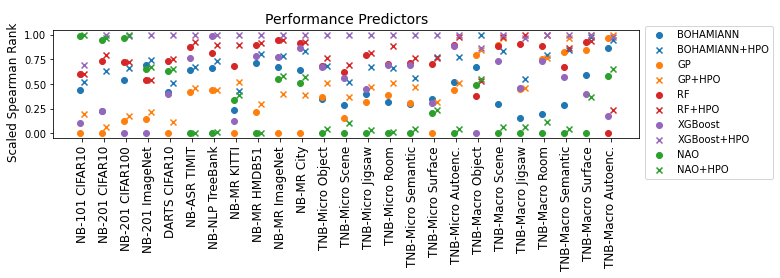

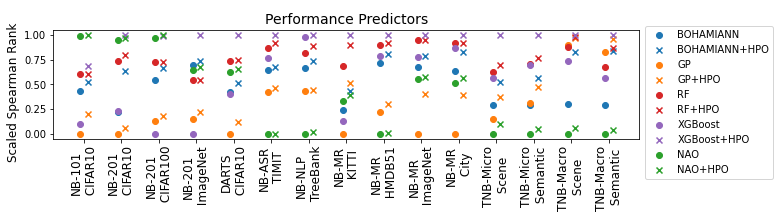

In [191]:
# plot the full results:
plot_default_hpo(results, search_spaces, predictors, one_line=True, scale_type='0-1') #, save='predictors.pdf')

# plot a representative subset:
ss_group = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp', \
            'mr_3ddet', 'mr_video', 'mr_cls', 'mr_seg', \
            'transmicro_scene', 'transmicro_segment', 'transmacro_scene', 'transmacro_segment']
plot_default_hpo(results, ss_group, predictors, scale_type='0-1') #, save='predictors.pdf')

In [383]:
# compute the average ranks of the predictors, and the number of wins
# we give weight 1 to each search space, including the ones with multiple datasets (nb201, trans, mr)
# (correctly weighing each search_space,dataset pair makes the code a bit more complex)

def compute_ranks(results, predictors):
    rank_results = []
    full_ranks_no_hpo = None
    full_ranks_hpo = None
    for hpo in [False, True]:
        ranks = np.zeros((len(search_spaces), len(predictors)))
        nb201_indices = []
        trans_indices = []
        mr_indices = []
        for i, search_space in enumerate(results[0].keys()):
            values = []
            for predictor in predictors:
                if not hpo:
                    values.append(results[0][search_space][predictor][0])
                else:
                    means = []
                    for hpo_seed in results.keys():
                        if predictor in results[hpo_seed][search_space]:
                            means.append(results[hpo_seed][search_space][predictor][0])
                    values.append(np.max(means))
            ranks[i] = np.flip(np.array(values).argsort()).argsort()
            if 'nb201' in search_space:
                nb201_indices.append(i)
            elif 'trans' in search_space:
                trans_indices.append(i)
            elif 'mr' in search_space:
                mr_indices.append(i)
                
        # compute num_wins
        num_wins = [0 for i in range(len(predictors))]
        for i in range(len(ranks)):
            if i in nb201_indices:
                num_wins[np.argmin(ranks[i])] += 1/3
            elif i in trans_indices:
                num_wins[np.argmin(ranks[i])] += 1/14
            elif i in mr_indices:
                num_wins[np.argmin(ranks[i])] += 1/4                
            else:
                num_wins[np.argmin(ranks[i])] += 1
                
        # scale by weight
        for i in nb201_indices[1:]:
            ranks[nb201_indices[0]] += ranks[i]
        ranks[nb201_indices[0]] /= 3
            
        for i in trans_indices[1:]:
            ranks[trans_indices[0]] += ranks[i]
        ranks[trans_indices[0]] /= 14
        
        for i in mr_indices[1:]:
            ranks[mr_indices[0]] += ranks[i]
        ranks[mr_indices[0]] /= 4

        indices_to_delete = [*nb201_indices[1:], *trans_indices[1:], *mr_indices[1:]]
        indices_to_delete.sort(reverse=True)

        for i in indices_to_delete:
            ranks = np.delete(ranks, i, axis=0)

        if not hpo:
            full_ranks_no_hpo = ranks
        else:
            full_ranks_hpo = ranks
        avg_ranks = np.mean(ranks, axis=0) + 1
        rank_results.append(avg_ranks)
        rank_results.append(num_wins)

    print("\t Avg. rank, default\t Num. wins, default\t Avg. rank, HPO\t Num. wins, HPO")
    for i, predictor in enumerate(predictors):
        # print in readable format
        if i == 0:
            print(predictor, *[str(np.round(rank_results[j][i], 2))+'\t\t\t' for j in range(len(rank_results))])
        else:
            print(predictor, '\t', *[str(np.round(rank_results[j][i], 2))+'\t\t\t' for j in range(len(rank_results))])
            
    for i, predictor in enumerate(predictors):
        # print in latex format
        print(pred_label_dict[predictor], '&', *[str(np.round(rank_results[j][i], 2))+' &' for j in range(len(rank_results))])
    return full_ranks_no_hpo, full_ranks_hpo

In [385]:
full_ranks_no_hpo, full_ranks_hpo = compute_ranks(results, predictors)

	 Avg. rank, default	 Num. wins, default	 Avg. rank, HPO	 Num. wins, HPO
bohamiann 2.99			 0.33			 3.36			 0.07			
gp 	 4.25			 0.29			 4.37			 0.07			
rf 	 1.57			 3.71			 2.41			 0.14			
xgb 	 2.95			 1			 1.23			 5.38			
nao 	 3.25			 1.67			 3.62			 1.33			
BOHAMIANN & 2.99 & 0.33 & 3.36 & 0.07 &
GP & 4.25 & 0.29 & 4.37 & 0.07 &
RF & 1.57 & 3.71 & 2.41 & 0.14 &
XGBoost & 2.95 & 1 & 1.23 & 5.38 &
NAO & 3.25 & 1.67 & 3.62 & 1.33 &


In [431]:
# compute correlation between algo performance and {size, RWA}
algo_rankings = {
    'no_hpo':full_ranks_no_hpo,
    'hpo':full_ranks_hpo
}
# 101, 201, darts, asr, nlp, trans, mr
ss_rankings = {
    'ss_sizes':[432625, 6466, 1e18, 8242, 1e53, 3676, 1e23],
    'nbhd_sizes':[20.114, 24, 120, 21, 42, 15, 45.3],
}

for key1, ss_rank in ss_rankings.items():
    for key2, alg_rankings in algo_rankings.items():
        res = []
        for i, predictor in enumerate(predictors):        
            alg_rank = [ss[i] for ss in alg_rankings]
            value = kendalltau(alg_rank, ss_rank)[0]
            s = str(np.round(value, 2))
            if s[0] == '-':
                s = '-' + s[2:]
            else:
                s = s[1:]
            res.append(s + ' & ')
            # print in readable format:
            print(value, key1, key2, predictor)

        # print in latex format:
        print(key1, key2, ''.join(res))


-0.0657951694959769 ss_sizes no_hpo bohamiann
0.2503130871608794 ss_sizes no_hpo gp
-0.15877683720748895 ss_sizes no_hpo rf
-0.39036002917941326 ss_sizes no_hpo xgb
0.19518001458970663 ss_sizes no_hpo nao
ss_sizes no_hpo -.07 & .25 & -.16 & -.39 & .2 & 
0.15018785229652765 ss_sizes hpo bohamiann
0.05292561240249632 ss_sizes hpo gp
-0.50709255283711 ss_sizes hpo rf
-0.3944053188733077 ss_sizes hpo xgb
0.19518001458970663 ss_sizes hpo nao
ss_sizes hpo .15 & .05 & -.51 & -.39 & .2 & 
-0.3289758474798845 nbhd_sizes no_hpo bohamiann
0.45056355688958294 nbhd_sizes no_hpo gp
-0.2646280620124816 nbhd_sizes no_hpo rf
0.0 nbhd_sizes no_hpo xgb
0.0 nbhd_sizes no_hpo nao
nbhd_sizes no_hpo -.33 & .45 & -.26 & .0 & .0 & 
0.3504383220252312 nbhd_sizes hpo bohamiann
0.3704792868174742 nbhd_sizes hpo gp
-0.3944053188733077 nbhd_sizes hpo rf
-0.50709255283711 nbhd_sizes hpo xgb
0.0 nbhd_sizes hpo nao
nbhd_sizes hpo .35 & .37 & -.39 & -.51 & .0 & 


In [410]:
"""
plot a matrix where entry [i,j] is the regret of a predictor 
tuned on search space i and evaluated on search space j.

Some of the matrix code is different types of scaling so that we can see the trends better
"""
def compute_matrix(results, ss_group, predictors, predictor):

    # first, compute a list of all seeds that have full info
    hpo_seeds = []
    for hpo_seed in results.keys():
        valid = True
        for search_space in ss_group:
            for pred in predictors:
                if not (search_space in results[hpo_seed] and \
                        pred in results[hpo_seed][search_space]):
                    valid = False
        if valid:
            hpo_seeds.append(hpo_seed)
        else:
            pass
    print('num valid', len(hpo_seeds))

    # now compute the raw results and best seed for each search space
    best_seeds = []
    raw_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    scaled_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    for i, search_space in enumerate(ss_group):
        raw_seed_results[i] = [results[hpo_seed][search_space][predictor][0] for hpo_seed in hpo_seeds]
        best_seeds.append(np.argmax(raw_seed_results[i]))
        # 0-1 scaling:
        min_acc, max_acc = np.min(raw_seed_results[i]), np.max(raw_seed_results[i])
        scaled_seed_results[i] = [(m - min_acc) / (max_acc - min_acc) for m in raw_seed_results[i]]

    # compute the matrices
    div_matrix = np.zeros((len(ss_group), len(ss_group)))
    kt_matrix = np.zeros((len(ss_group), len(ss_group)))
    scaled_matrix = np.zeros((len(ss_group), len(ss_group)))

    for i, ss_1 in enumerate(ss_group):
        for j, ss_2 in enumerate(ss_group):
            div_matrix[i][j] = scaled_seed_results[i][best_seeds[j]] / scaled_seed_results[i][best_seeds[i]]
            scaled_matrix[i][j] = scaled_seed_results[i][best_seeds[i]] - scaled_seed_results[i][best_seeds[j]]
            kt_matrix[i][j] = kendalltau(raw_seed_results[i], raw_seed_results[j])[0]

    return div_matrix, scaled_matrix, kt_matrix, scaled_seed_results

def scale_matrix(matrix, mean_div=2.5):
    # further scaling of the results
    # needs to happen in its own method so that an avg_matrix is input
    scaled_matrix = np.zeros((len(matrix), len(matrix)))
    maximum = np.max(matrix)
    mean = np.mean(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if mean_div > 0:
                scaled_matrix[i][j] = np.minimum(matrix[i][j], mean * mean_div)
            else:
                scaled_matrix[i][j] = np.maximum(matrix[i][j], mean / mean_div * -1)

    # 0-1 scale
    min_acc, max_acc = np.min(scaled_matrix), np.max(scaled_matrix)
    for i in range(len(scaled_matrix)):
        for j in range(len(scaled_matrix)):
            scaled_matrix[i][j] = (scaled_matrix[i][j] - min_acc) / (max_acc - min_acc) 

    return scaled_matrix

def plot_matrix(matrix, ss_group, save=None, cmap='viridis', hparam=False):
    coords = matrix
    cellsize = 5
    fig, ax = plt.subplots(1,1,figsize=(cellsize*1.2, cellsize*coords.shape[0]/coords.shape[1]))
    im = ax.pcolormesh(coords, edgecolor='k', linewidth=0.5, cmap=cmap) 
    if hparam:
        plt.title('HParam. Corr. for Predictors')
    else:
        plt.title('Generalizability for Predictors')
    plt.gca().invert_yaxis()
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xticks([c+0.5 for c in range(coords.shape[0]-0)], minor=True)
    ax.set_xticklabels([ss_dict_mat[ss] for ss in ss_group], minor=True, rotation=90)
    ax.set_yticks([])
    ax.set_yticklabels('')    
    ax.set_yticks([c+0.5 for c in range(coords.shape[1]-0)], minor=True)
    ax.set_yticklabels([ss_dict_mat[ss] for ss in ss_group], minor=True)
    fig.colorbar(im, ax=ax)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)
        
    return matrix

num valid 295
num valid 295
num valid 295
num valid 295
num valid 295


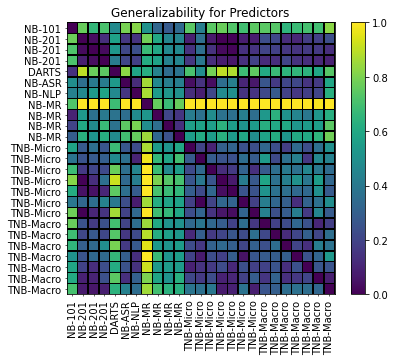

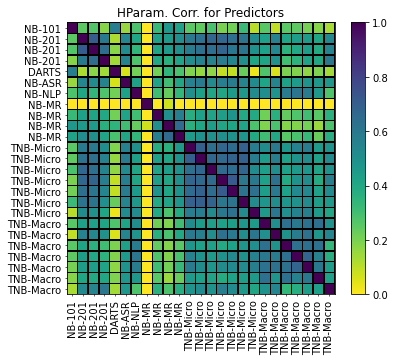

In [414]:
matrices = []
kt_matrices = []
for predictor in predictors:
    _, mat, kt_mat, _ = compute_matrix(results, search_spaces, predictors, predictor=predictor)
    matrices.append(mat)
    kt_matrices.append(kt_mat)

avg_matrix = np.mean(np.array(matrices), axis=0)
avg_kt_matrix = np.mean(np.array(kt_matrices), axis=0)

scaled_matrix = scale_matrix(avg_matrix, mean_div=2.5)
scaled_kt_matrix = scale_matrix(avg_kt_matrix, mean_div=-100000)

_ = plot_matrix(scaled_matrix, search_spaces, cmap='viridis') #, save='pred_matrix_avg.pdf')
_ = plot_matrix(scaled_kt_matrix, search_spaces, cmap='viridis_r', hparam=True) #, save='pred_corr_matrix.pdf')

In [415]:
def shorten_matrix(matrix):
    # this has hard-coded indices for groups of search_spaces
    if len(matrix) != 25:
        print('invalid matrix')
        return

    # compute a smaller matrix based on just ss_groups
    # the search spaces with multiple datasets (nb201, mr, trans) are hard-coded.
    ss_idx_groups = [[0], [1,2,3], [4], [5], [6], [7,8,9,10], [i for i in range(11,25)]]
    ss_matrix = np.zeros((len(ss_idx_groups), len(ss_idx_groups)))
    for i, ss_1 in enumerate(ss_idx_groups):
        for j, ss_2 in enumerate(ss_idx_groups):
            ss_matrix[i][j] = np.mean(matrix[ss_1, :][:, ss_2])

    if False:
        # debug by looking at the matrix
        coords = ss_matrix
        cellsize = 5
        fig, ax = plt.subplots(1,1,figsize=(cellsize*1.2, cellsize*coords.shape[0]/coords.shape[1]))
        im = ax.pcolormesh(coords, edgecolor='k', linewidth=0.5) 
        plt.title('Generalizability for Predictors')
        plt.gca().invert_yaxis()
        fig.colorbar(im, ax=ax)
    return ss_matrix

def summarize_matrix(matrix):
    # compute the average transfer score
    to_avgs = []
    from_avgs = []
    adjustment = len(matrix) / (len(matrix) - 1)
    for i in range(len(matrix)):
        to_avgs.append(np.mean(matrix[i,:]) * adjustment)
        from_avgs.append(np.mean(matrix[:,i]) * adjustment)
    mean_avgs = np.mean([to_avgs, from_avgs], axis=0)
    to_avgs = np.round(to_avgs, 3)
    from_avgs = np.round(from_avgs, 3)
    mean_avgs = np.round(mean_avgs, 3)
    print(*[str(t) + ' &' for t in to_avgs])
    print(*[str(t) + ' &' for t in from_avgs])
    print(mean_avgs)  

In [430]:
shortened_matrix = shorten_matrix(avg_matrix)
print('summary of matrix (with 0-1 scaling)')
rounded = np.round(shortened_matrix, 2)

for row in rounded:
    print(*[str(i)[1:] + ' &' for i in row])
print()

summarize_matrix(shortened_matrix)

summary of matrix (just 0-1 scaling)
.0 & .42 & .28 & .46 & .48 & .21 & .41 &
.43 & .02 & .29 & .11 & .11 & .32 & .09 &
.08 & .47 & .0 & .48 & .34 & .26 & .41 &
.28 & .23 & .31 & .0 & .07 & .32 & .12 &
.25 & .31 & .27 & .09 & .0 & .36 & .15 &
.19 & .39 & .28 & .42 & .47 & .2 & .4 &
.37 & .13 & .41 & .16 & .15 & .4 & .15 &

0.376 & 0.229 & 0.34 & 0.224 & 0.239 & 0.393 & 0.293 &
0.268 & 0.328 & 0.307 & 0.288 & 0.27 & 0.345 & 0.287 &
[0.322 0.279 0.323 0.256 0.254 0.369 0.29 ]


In [423]:
# leave one out experiment
def leave_one_out(seed_results):
    # first shorten the tensor
    if seed_results.shape[0] != 25:
        print('invalid seed results')
        return

    # compute a smaller matrix based on just ss_groups
    ss_idx_groups = [[0], [1,2,3], [4], [5], [6], [7,8,9,10], [i for i in range(11,25)]]
    ss_seed_results = np.zeros((len(ss_idx_groups), seed_results.shape[1]))
    for i, ss in enumerate(ss_idx_groups):
        ss_seed_results[i] = np.mean(seed_results[ss, :], axis=0)
        
        # 0-1 scaling:
        min_acc, max_acc = np.min(ss_seed_results[i]), np.max(ss_seed_results[i])
        ss_seed_results[i] = [(m - min_acc) / (max_acc - min_acc) for m in ss_seed_results[i]]

    # now compute leave one out regret values
    loo_to = []
    loo_from = []
    for i, ss_1 in enumerate(ss_seed_results):
        avg_minus_i = np.mean(np.array([row for j,row in enumerate(ss_seed_results) if j != i]), axis=0)
        best_minus_i_idx = np.argmax(avg_minus_i)
        best_i_idx = np.argmax(ss_seed_results[i])
        loo_to.append(ss_seed_results[i][best_i_idx] - ss_seed_results[i][best_minus_i_idx])
        loo_from.append(avg_minus_i[best_minus_i_idx] - avg_minus_i[best_i_idx])

    print(*[str(i) + ' &' for i in np.round(loo_to, 3)])
    print(*[str(i) + ' &' for i in np.round(loo_from, 3)])

In [424]:
leave_one_out(avg_seed_results)

0.372 & 0.37 & 0.48 & 0.195 & 0.185 & 0.445 & 0.252 &
0.226 & 0.16 & 0.223 & 0.058 & 0.029 & 0.241 & 0.056 &


In [146]:
# this is used to compare the best predictors on nb101 and nb201 vs best on every other search space
def compute_subsets(results, predictors, ss_group, ss_indices_1, ss_indices_2):
    rank_results = []
    print(predictors)
    for hpo in [False, True]:
        ranks = np.zeros((len(search_spaces), len(predictors)))
        nb201_indices = []
        trans_indices = []
        mr_indices = []
        for i, search_space in enumerate(ss_group):
            values = []
            for predictor in predictors:
                if not hpo:
                    values.append(results[0][search_space][predictor][0])
                else:
                    means = []
                    for hpo_seed in results.keys():
                        if predictor in results[hpo_seed][search_space]:
                            means.append(results[hpo_seed][search_space][predictor][0])
                    values.append(np.max(means))
            ranks[i] = np.flip(np.array(values).argsort()).argsort()
            if 'nb201' in search_space:
                nb201_indices.append(i)
            elif 'trans' in search_space:
                trans_indices.append(i)
            elif 'mr' in search_space:
                mr_indices.append(i)
                
        # scale by weight
        for i in nb201_indices[1:]:
            ranks[nb201_indices[0]] += ranks[i]
        ranks[nb201_indices[0]] /= 3
            
        for i in trans_indices[1:]:
            ranks[trans_indices[0]] += ranks[i]
        ranks[trans_indices[0]] /= 14
        
        for i in mr_indices[1:]:
            ranks[mr_indices[0]] += ranks[i]
        ranks[mr_indices[0]] /= 4

        indices_to_delete = [*nb201_indices[1:], *trans_indices[1:], *mr_indices[1:]]
        indices_to_delete.sort(reverse=True)

        for i in indices_to_delete:
            ranks = np.delete(ranks, i, axis=0)
               
        ranks_1, ranks_2 = [], []
        for i in range(len(ranks)):
            if i in ss_indices_1:
                ranks_1.append(ranks[i])
            elif i in ss_indices_2:
                ranks_2.append(ranks[i])
                
        avg_ranks = np.mean(ranks, axis=0) + 1
        avg_ranks_1 = np.mean(ranks_1, axis=0) + 1
        avg_ranks_2 = np.mean(ranks_2, axis=0) + 1
        
        avg_ranks_1 = [np.round(a, 2) for a in avg_ranks_1]
        avg_ranks_2 = [np.round(a, 2) for a in avg_ranks_2]
        avg_ranks = [np.round(a, 2) for a in avg_ranks]

        print('a:', *[str(a)+' &' for a in avg_ranks])
        print('1:', *[str(a)+' &' for a in avg_ranks_1])
        print('2:', *[str(a)+' &' for a in avg_ranks_2])
        
        rank_results.append(avg_ranks)

    #print(rank_results)

In [194]:
full_ss = ['nb101', 
           'nb201_c10', 'nb201_c100', 'nb201_im',
           'darts', 
           'asr', 
           'nlp',
           'mr_cls', 'mr_3ddet', 'mr_seg', 'mr_video',
           'transmicro_obj', 'transmicro_scene', 'transmicro_jigsaw', 
           'transmicro_room', 'transmicro_segment', 'transmicro_normal', 
           'transmicro_auto', 'transmacro_obj', 'transmacro_scene', 'transmacro_jigsaw', 
           'transmacro_room', 'transmacro_segment', 'transmacro_normal', 
           'transmacro_auto']

ss_indices_1 = [0, 1]
ss_indices_2 = [2, 3, 4, 5, 6]


compute_subsets(results, predictors, full_ss, ss_indices_1, ss_indices_2)

('bohamiann', 'gp', 'rf', 'xgb', 'nao')
a: 2.99 & 4.25 & 1.57 & 2.95 & 3.25 &
1: 2.83 & 4.67 & 2.17 & 4.17 & 1.17 &
2: 3.06 & 4.08 & 1.33 & 2.46 & 4.08 &
a: 3.36 & 4.37 & 2.41 & 1.23 & 3.62 &
1: 3.67 & 5.0 & 3.17 & 1.67 & 1.5 &
2: 3.24 & 4.12 & 2.11 & 1.06 & 4.47 &
